<a href="https://colab.research.google.com/github/le0x99/BrainImaging/blob/main/clean_start.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Notebook Introduction

Welcome to the main project notebook! 

## What is the goal of this notebook?

This notebook should contain your project write-up and the analyses conducted on the provided data. For each project, the notebook provides links to a few articles on the subject of the notebook, and a few examples of analyses that you could/should do. But it is not at all exhaustive: If you need to install more python packages or other software, do so. If you want to search for additional literature to support your writing, do so!

Your goal is to work from these examples towards answering the list of questions specific to each of the projects, and write a coherent report following the structure at the bottom of this notebook. Your colleagues (and I) will read and grade the result. So, make sure that you provide ample and adequate descriptions of your results and methodologies. This notebook is likely going to get rather large as you add analyses, so best to use markdown cells and headings to create a table of contents structure, as you can see in the ToC menu on the left of the Colab user interface.  

If this project feels a bit open-ended, that's because it is - just like actual research! ***But you are not alone!*** You will collaborate with your fellow students in your group! I also want to push you towards asking any and all questions in the canvas discussions, and directly to me via email and the Friday Zoom meetings. I'm here to help, and will give hints if you ask me the right questions. 

You are free to make this as beautiful and far-reaching as you feel like. But keep track of time, you will need to finish this the week before the exam. Perfect is the enemy of good, beware. 


## Installation etc.

The first part of this notebook is shared across the different projects, as the notebook will download the data for all the projects in the same way. 

The first installation and setup cells may take a little while to run as they fetch and install all the required software. It's also likely there's going to be a LOT of outputs that are irrelevant. Feel free to delete the output of this cell after it runs to free up space. 

In [ ]:
# this cell installs some dependencies. 
# feel free to disregard the output this generates

!apt -qq install inkscape > /dev/null
!pip -qq install nibabel nilearn
!pip -qq install git+https://github.com/gallantlab/pycortex.git#egg=pycortex



Extracting templates from packages: 100%
     |████████████████████████████████| 3.1MB 5.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.6MB 4.1MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [ ]:
# after these basic installs, we can import our required packages. 

import numpy as np
import scipy as sp
import nibabel as nb
import nilearn as nl
from nilearn.surface import load_surf_data
import os, shutil, urllib.request

from matplotlib import rc
rc('animation', html='jshtml')

import matplotlib.pyplot as plt
%matplotlib inline 

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


### Download of data: surfaces for plotting and project data

Both the surface data we'll use for visualization and the project fMRI data are on figshare. From Figshare, we can download the data and place them in the Colab virtual machine. You don't have to read/understand this code - it's all boilerplate stuff to set up Colab's virtual machine so that it works with our data. 

***More important:*** For a brief description of the data of the different projects, --and a couple of very important parameters of these acquisitions which you will need later-- please consult the [figshare website](https://figshare.com/articles/dataset/fMRI_Teaching_Materials/14096209)

In [ ]:
#
# this cell ensures that we can work with our own surface from within the colab environment
#

os.makedirs('/content/pycortex/db', exist_ok=True)
os.makedirs('/content/pycortex/colormaps', exist_ok=True)
os.makedirs('/content/data', exist_ok=True)

wrong_filestore_location = 'build/bdist.linux-x86_64/wheel/pycortex-1.3.0.dev0.data/data/share/pycortex/'
with open('/usr/local/lib/python3.7/dist-packages/cortex/defaults.cfg', 'r') as f:
  file_source = f.read()
replace_string = file_source.replace(wrong_filestore_location, '/content/pycortex/') #save output 
with open('/usr/local/lib/python3.7/dist-packages/cortex/defaults.cfg', 'w') as f:
  f.write(replace_string)   

os.chdir('/tmp/')
!git clone https://github.com/gallantlab/pycortex.git
!cp /tmp/pycortex/filestore/colormaps/* /content/pycortex/colormaps/

#
# and we'll download our average hcp subject for pycortex visualization
#

pycortex_sj_URL = "https://ndownloader.figshare.com/files/25768841"

urllib.request.urlretrieve(pycortex_sj_URL, os.path.join('/content/pycortex/db', 'hcp_999999.zip'))
!unzip -qq /content/pycortex/db/hcp_999999.zip -d /content/pycortex/db/

#
# and then download the projects' data from figshare
#

timeseries_data_URL = 'https://ndownloader.figshare.com/articles/14096209/versions/3'
urllib.request.urlretrieve(timeseries_data_URL, os.path.join('/content/data', '14096209.zip'))
!unzip -qq /content/data/14096209.zip -d /content/data/
!unzip -qq /content/data/hrf_mapper_59k.zip -d /content/data/hrf_mapper_59k/
!unzip -qq /content/data/prf_mapper_59k.zip -d /content/data/prf_mapper_59k/
!unzip -qq /content/data/soma_mapper_59k.zip -d /content/data/soma_mapper_59k/
!unzip -qq /content/data/atlas.zip -d /content/data/

Cloning into 'pycortex'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (202/202), done.
remote: Compressing objects: 100% (174/174), done.
remote: Total 21798 (delta 106), reused 76 (delta 28), pack-reused 21596
Receiving objects: 100% (21798/21798), 289.15 MiB | 33.47 MiB/s, done.
Resolving deltas: 100% (16788/16788), done.


## Putting these tools to first use

Ok, why all this complicated hassle? Well, we want you to have a playground that allows you to really get to know the data. 

#### Where are the data files?

The data have now been downloaded, and you can check out the data on disk by using the command line. For example, in a code cell you can preface the line with an exclamation mark to give a commandline command: 

`!ls /content/data/prf_mapper_59k`

Will give you the contents of the prf experiment data folder. But, on the left in the CoLab UI you can also find a file navigator, next to the table of contents, search and code snippet elements. Feel free to have a look around!

#### Okay, but what can we do with these tools?

After downloading and auto-editing the data required for working with pycortex, we can now import pycortex. We'll use pycortex for plotting of the results, which is using only a subset of its awesome features. Remember that [brain viewer of semantic maps](http://gallantlab.org/huth2016/)? Also made using pycortex! If you have some spare time and want to play around with this awesome package, please have a look at the [pycortex docs](https://gallantlab.github.io/pycortex/)

In [ ]:
import cortex as cx

And, just to highlight the type of visualisation we'll be doing, a quick demo of the way we'll be using it. We'll be using the surface from the Human Connectome Project, which we named `hcp_999999`. So that's the 'subject' name we use to get and plot surface data using pycortex. 

Don't worry if you see a bunch of warnings and stuff - it will create the figure we asked for from what is in essence a single line of code: the curvature of the cortical surface of this standard surface. **Gorgeous!** 

Feel free to change the datatype to `'thickness'`, for example. Also **Gorgeous!**

Generating a flatmap cache
Failed to get connection
** (inkscape:3290): CRITICAL **: 20:08:58.542: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed
** (inkscape:3290): CRITICAL **: 20:08:58.542: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed
** (inkscape:3290): CRITICAL **: 20:08:58.542: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed


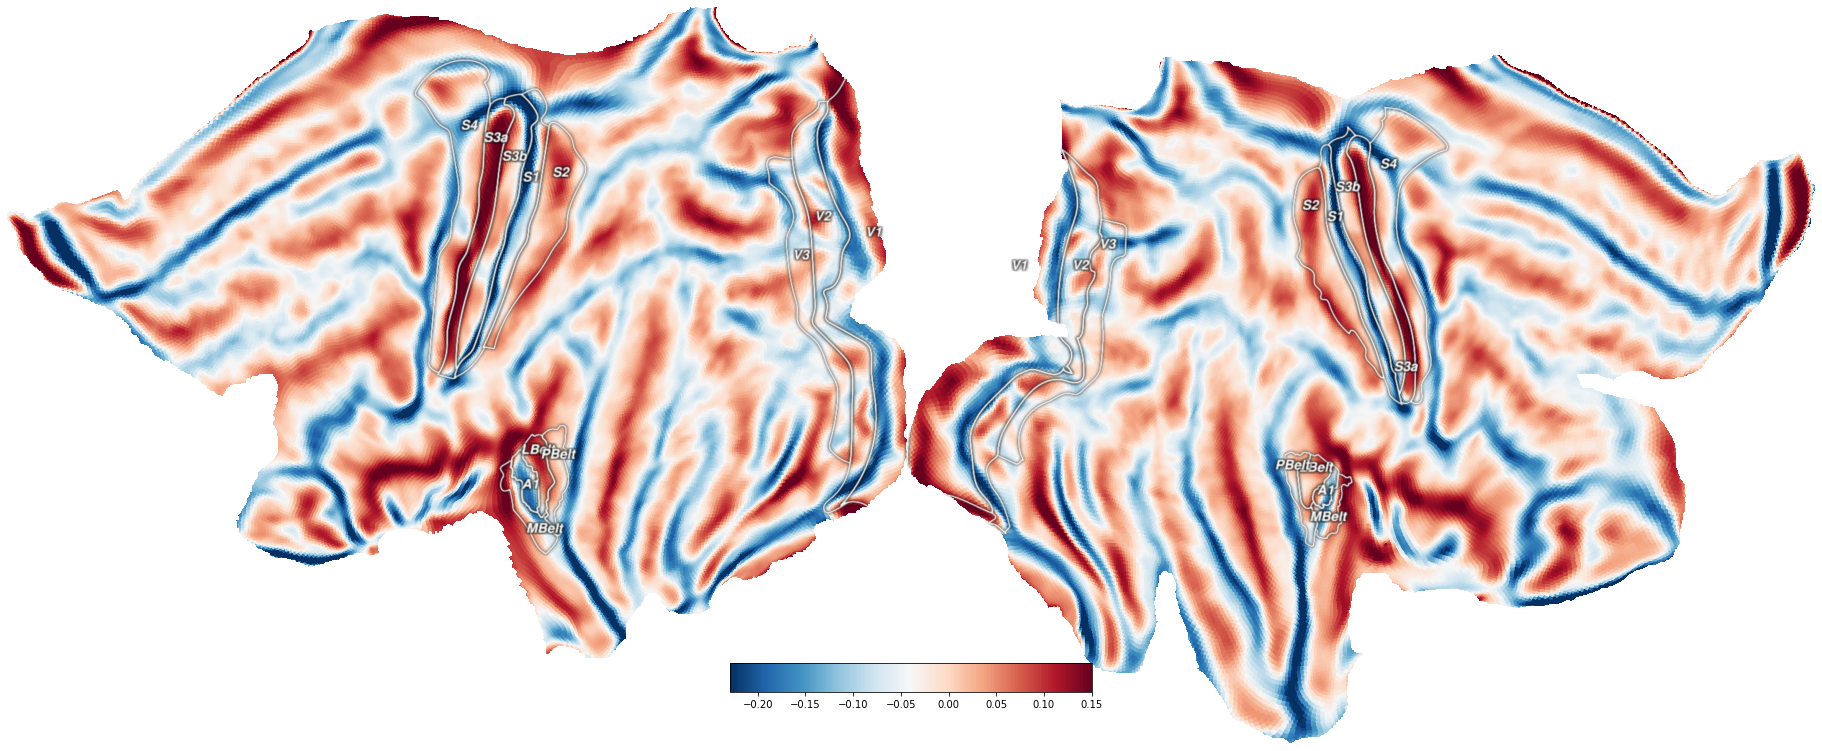

In [ ]:
curv_vertices = cx.db.get_surfinfo(subject='hcp_999999', type='curvature')
cx.quickshow(curv_vertices);

### Flatmaps?

But what the hell are we looking at, even? The cortical surface or ribbon is topologically a ball per hemisphere. That is, each hemisphere can be inflated to the shape of a sphere (let's not get stuck on the question how a hemisphere can also be a sphere :-) ). Flatmaps are created by cutting the inflated cortical surface at specific locations (see the black lines in the left figure), and then letting the computer flatten the resulting mesh into a planar surface. 

<img src="https://github.com/VU-Cog-Sci/wiki/raw/master/imgs/flatten/image9.png" alt="where do we cut the surface" width="45%" style="align:left;"/> <img src="https://universe-review.ca/I10-13-BrainMap3.jpg" alt="Visual, auditory and somatosensory brain regions" width="45%" style="align:right;"/>

This flatmapping has the advantage that we can view the entire cerebral cortex in one fell swoop, but the downside is that it is hard to orient yourself to where things are. That's why we've added some lines that surround certain labeled regions of interest - they are the visual, auditory and somatosensory/motor cortex. In the right image they are the blue, red and green areas of the brain, respectively. We're using exactly the flattened surfaces of the right column in the right figure, but ours are rendered side-by-side. Recognize them from the curvature figure?

Take a few minutes to orient yourself on these surfaces, using the atlas in the right figure. Where are the darker areas of this atlas on the inflated surfaces, and where do they end up on the flattened surface? Same for the coloured regions - make sure you have an idea of where things are. This will greatly increase your maneuverability in the brain. 

You'll need that maneuverability because we'll be working with surface data in this project: all the data you will load is surface-based, and should be visualized as shown in this introduction. In many ways, surface-based fMRI data is simpler than volume-based data. Instead of 4-dimensional, it's 2-dimensional: vertices by timepoints. This makes it less of a bookkeeping hassle to use. Let's have a look at some of your fMRI time-course data!


## Loading the functional data for your project

In the cell below we're loading the functional MRI files you'll be working with. There's a different set of files that you open and read depending on the project that you'll be doing. Once loaded, though, all of these datasets have the same format - they're all formatted for the same surface that you've already plotted data into. 

In [ ]:
# Here, I'm using python's awesome f-string functionality to load the data in a structured way across hemisperes. 
# Once the data have been loaded (for plotting and stuff), we don't have to care about hemispheres so much anymore. 
# There are 3 separate versions here, one for each project-dataset.


#########################################################################################################
###############
############### pRF mapping data
###############
#########################################################################################################

# tseries_raw = np.nan_to_num(np.concatenate([load_surf_data(
#         os.path.join('/content/data/prf_mapper_59k', f'sub-02_task-prf_space-59k_hemi-{hemi}_run-median_desc-bold.func.gii'))
#          for hemi in ['L', 'R']]))

#########################################################################################################
###############
############### somatotopic mapping data
###############
#########################################################################################################

#tseries_raw = np.concatenate([load_surf_data(
#        os.path.join('/content/data/soma_mapper_59k', f'sub-01_ses-01_task-soma_run-median_space-59k_hemi-{hemi}_sg_psc.dtseries.gii'))
#         for hemi in ['L', 'R']])

#########################################################################################################
###############
############### hrf mapping data
###############
#########################################################################################################

tseries_raw = np.concatenate([load_surf_data(
         os.path.join('/content/data/hrf_mapper_59k', f'sub-012_ses-2_task-hrfmapper_run-1_bold_space-T1w_preproc_59k.{hemi}.dtseries.gii'))
          for hemi in ['L', 'R']])


# and, we'll check the shape of the data to see whether things make sense
# data should be shaped as vertices by timepoints, and each hemisphere is 59k vertices - hence the name :) 
print(tseries_raw.shape)

(118584, 440)


## Raw Data Observations
### What amount of preprocessing has already been done?

If the signals have been filtered already, there should be no drifts in the data. Also, if the data time-courses have already been z-scored or converted to percent signal change, the mean of the signals should already be 0. If the data are in 'units' of % signal change, the maximal excursions of the signal timecourse will be on the order of 10-20. If they've been z-scored, their standard deviation should be exactly 1 (duh!). 

Like we learned in the preprocessing lecture and practical, the standard deviation over time also gives us a lot of valuable information regarding signal quality in non-z-scored data. Let's have a quick look at these different aspects of the data on flatmaps. This will also show us whether we were scanning the whole brain or not - an aspect of the data acquisition that you may want to mention in your report...

**Note**
If we plot data that didn't come from pycortex's surface data itself, but from our own files, we need to supply a subject. Adding the colormap is just for clarity. 

Failed to get connection
** (inkscape:3296): CRITICAL **: 20:09:04.910: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed
** (inkscape:3296): CRITICAL **: 20:09:04.910: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed
** (inkscape:3296): CRITICAL **: 20:09:04.910: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed
Failed to get connection
** (inkscape:3299): CRITICAL **: 20:09:06.385: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed
** (inkscape:3299): CRITICAL **: 20:09:06.385: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed
** (inkscape:3299): CRITICAL **: 20:09:06.385: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed


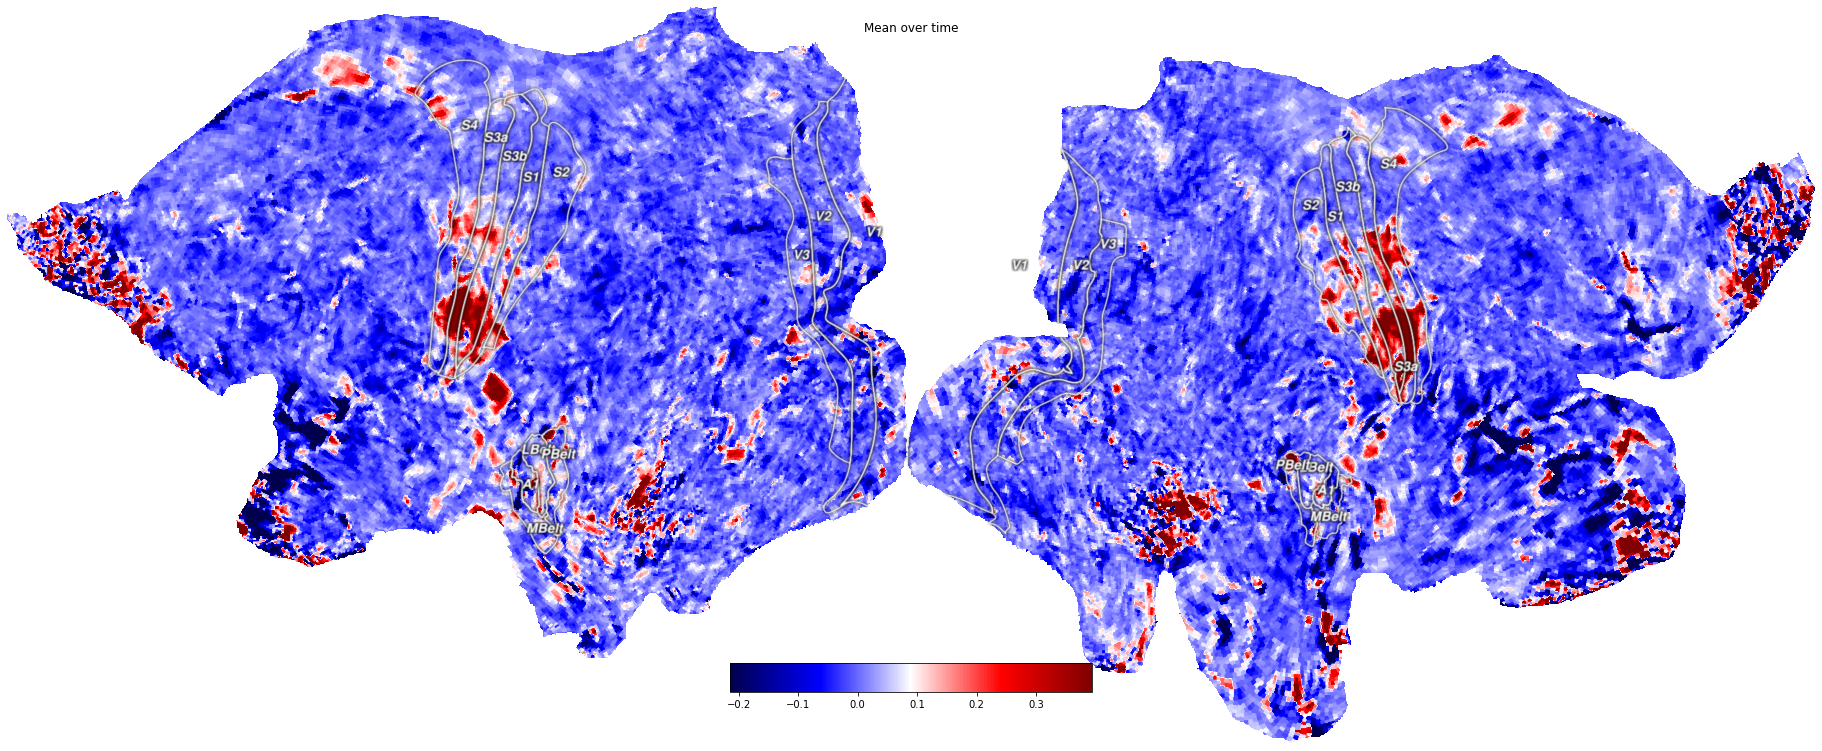

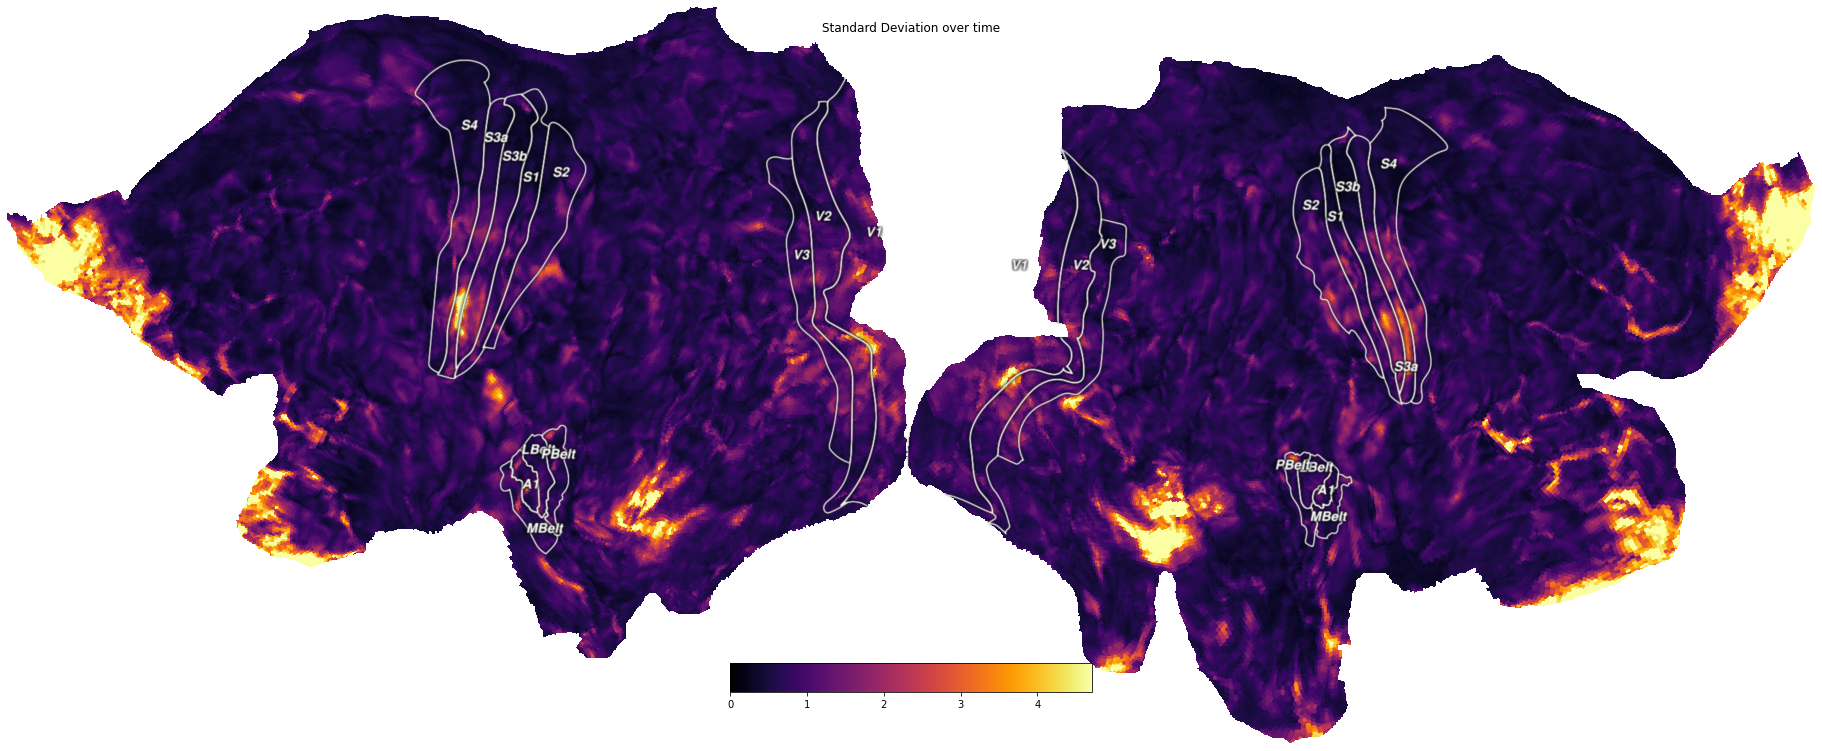

In [ ]:
# Note that we saw in the cell above that the second dimension is time, 
# so the axis on which we take the mean and standard deviation is 1
f = cx.quickshow(cx.Vertex(tseries_raw.mean(axis=1), subject='hcp_999999', cmap='seismic'));
f.suptitle('Mean over time')

f = cx.quickshow(cx.Vertex(tseries_raw.std(axis=1), subject='hcp_999999', cmap='inferno'));
f.suptitle('Standard Deviation over time');

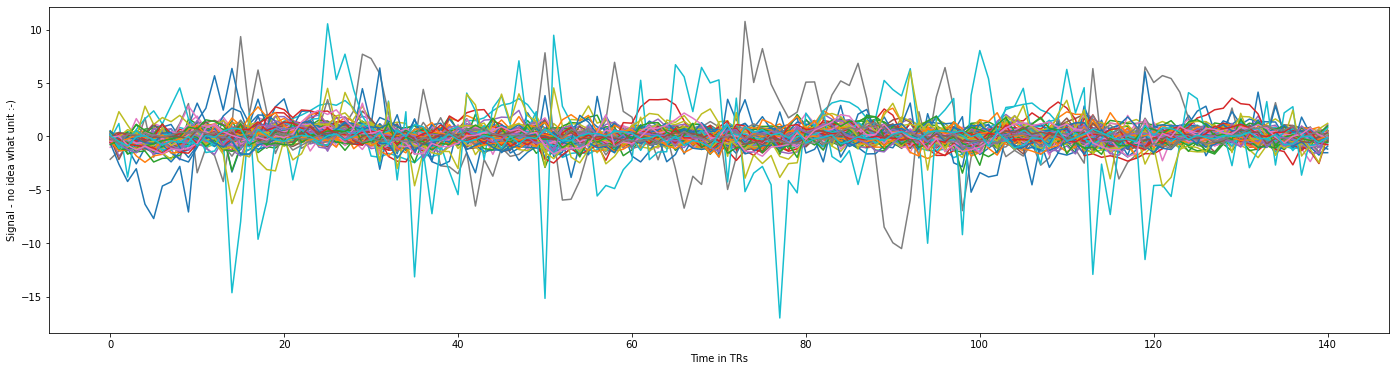

In [ ]:
# now, let's get some random time-courses to check whether there's still drift:
random_vertices = np.random.choice(np.arange(tseries_raw.shape[0]), 100)
f = plt.figure(figsize=(24,6))
plt.plot(tseries_raw[random_vertices].T)
plt.xlabel('Time in TRs')
plt.ylabel('Signal - no idea what unit :-)');

Now, depending on your dataset you may see that the top of the brain is brighter than the bottom. This is due to the fact that the top of the brain is closer to the coils. Moreover, you may see some really interesting web-like pattern on the surfaces that you've plotted. Like this:

<img style="float:right; align:right top; margin:10px; padding: 25px 25px 25px 25px;" src="https://i.imgur.com/lqPTAzK.png" alt="Model pipeline" width="500" align="right" />

What is that stuff? Why isn't it homogeneous? The answer is, we're looking at blood, and at 7 Tesla (at which all these data were acquired) these veins show up very strongly. Their presence has a strong influence on whether you can find any 'activation', as they may get in the way of what you want to find. Keep this in mind!

### Questions concerning signal quality

From these simple surface and time-course plots above, we can immediately gather a couple of things. Try to answer the following questions from both the flatmaps and the random time-courses. 

1.   have these data been z-scored or percent signal changed? **Check the colorbars!** What would they look like if they'd been z-scored?
2.   have these data been high-pass filtered? **Check the timecourses!**
3.   where do you see the biggest signal fluctuations? What are the likely origins of these fluctuations? 

You can use these insights in writing the data description section of your report! Note that there are differences between the different project-datasets, so make sure you inspect your own!

<font color='red'>-- Important: --</font>

**Your conclusions about the state of the data for your project will tell you what to do: you now have to decide whether to perform additional preprocessing, such as temporal filtering, percent signal change conversion, etc.**

## Atlas tools

It's a very powerful thing to be able to plot stuff on the entire cerebral cortex in one go. But sometimes you want to focus on a single brain region. You can use your own methods to define regions of interest, for example using a separate mapper experiment that allows you to select voxels/vertices of interest - within which you'll then perform your analysis of interest. 

But we'll use the existing multi-modal parcelation atlas from the Human Connectome Project, from the [Glasser et al Nature study](https://www.nature.com/articles/nature18933) that was mentioned a couple of times in the lectures. This is the atlas shown in the right flatmap figure above, in the 'Flatmaps' section.

The following cells show how to select a given ROI's data - something that you may want to do quite a lot in your own analyses. It serves to zoom into a specific region of interest, but also means that you can 'pilot' time-consuming analyses on smaller amounts of data while still taking care to test your entire analysis. 

In [ ]:
# we read in the atlas data, which consists of 180 separate regions per hemisphere. 
# These are labeled separately, so the labels go to 360. 
# To work with them in both hemispheres simultaneously, we mod by 180. 
atlas_data = np.concatenate([load_surf_data(
        os.path.join('/content/data/atlas', f'Q1-Q6_RelatedParcellation210.CorticalAreas_dil_Colors.59k_fs_LR.dlabel.{hemi}.gii'))
         for hemi in ['L', 'R']])
atlas_data_both_hemis = np.mod(atlas_data, 180)

### Selecting an ROI

One can now easily use a test to create boolean arrays into a specific ROI. For example, we can check which ROI is indexed by the number 1. Make sure you understand what I did with the `vmin` and `vmax` settings of the `Vertex` object! You may be able to use these little tricks later!

Failed to get connection
** (inkscape:3336): CRITICAL **: 20:26:09.364: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed
** (inkscape:3336): CRITICAL **: 20:26:09.364: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed
** (inkscape:3336): CRITICAL **: 20:26:09.364: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed


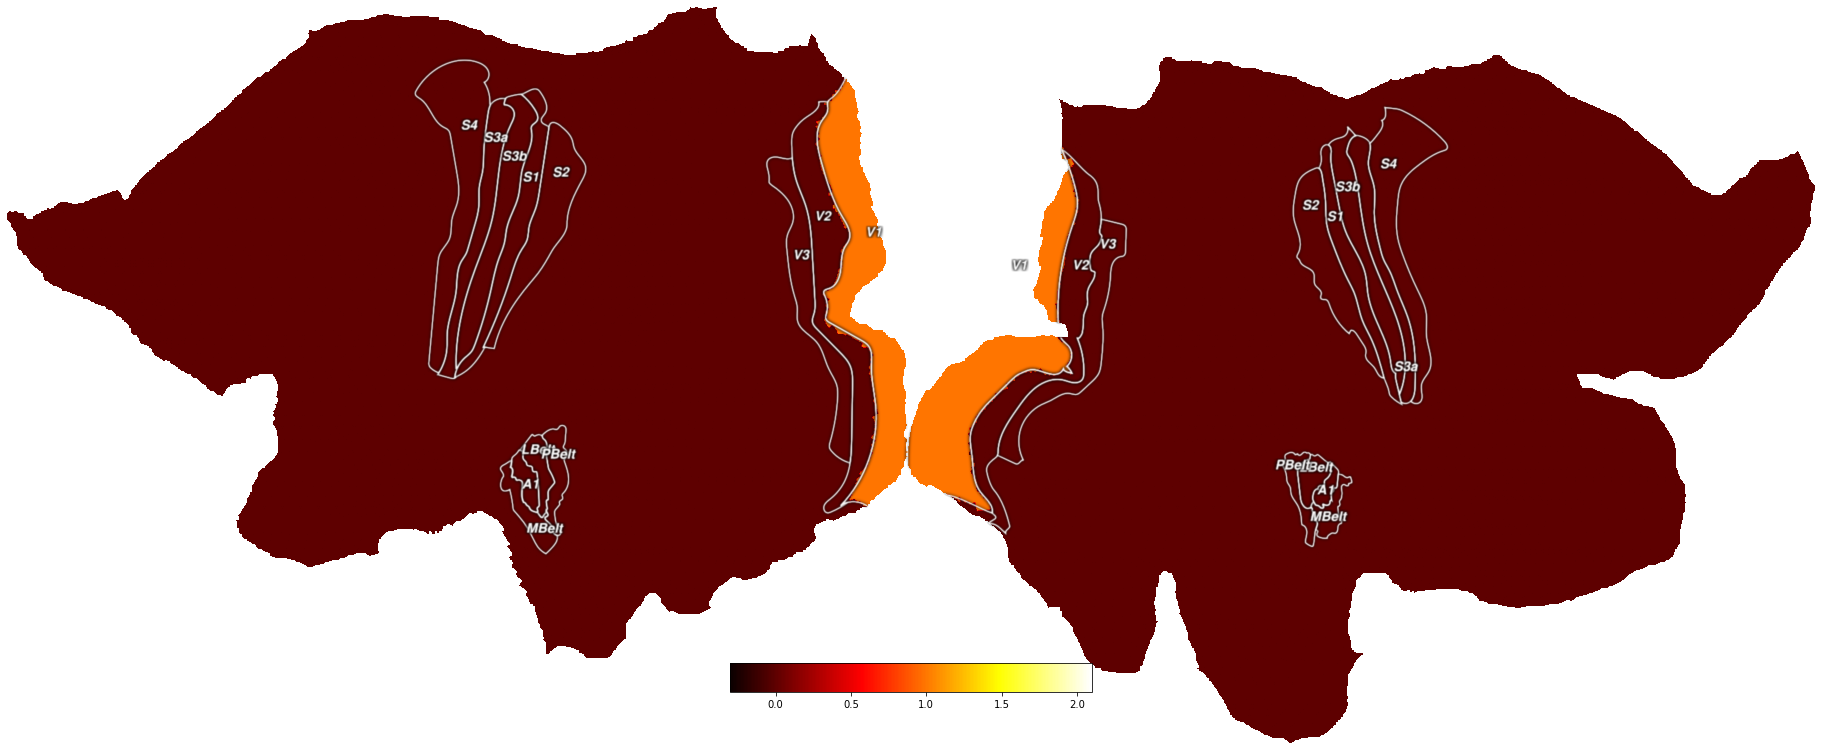

In [ ]:
f = cx.quickshow(cx.Vertex(atlas_data_both_hemis == 1, subject='hcp_999999', cmap='hot', vmin=-0.3, vmax=2.1));

This means we can also select those parts of the brain and single out the responses from just a single region of interest! That should be much more manageable. For now, we'll select the region we highlighted above, V1 - the first region of the cortical visual hierarchy. It turns out that 2 out of our 3 experiments did something very very visual, with the third also showing visual stimuli. So let's see what we end up with! Once you've understood the idea of the following code cell, feel free to experiment with the actual index of the ROI this analysis works with!

***Note 1:*** whether this raw data visualization is very informative depends on your experiment. So, don't worry if this doesn't show you anything here. 

***Note 2:*** See how I'm trying to label all my figure axes so that it's clear what the units and elements of the data are? **It's very important that you do the same for your report!**

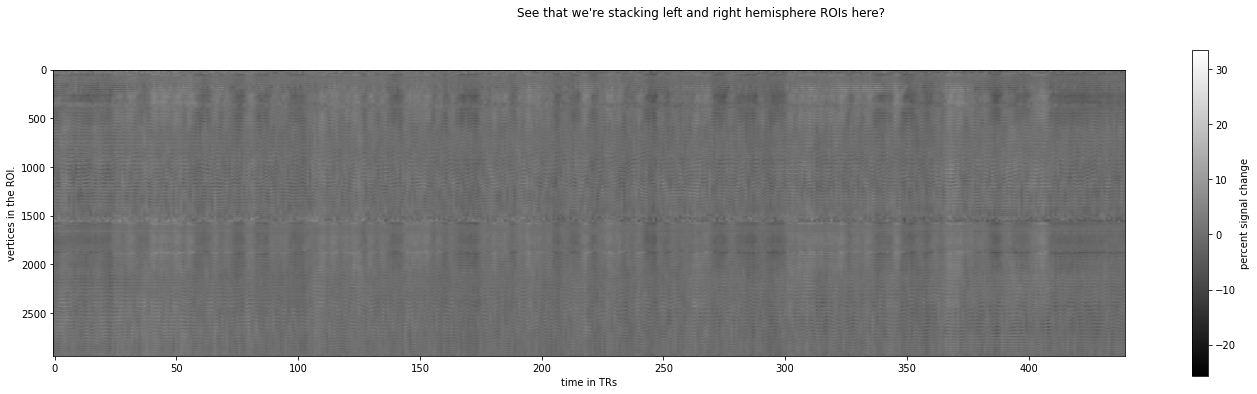

In [ ]:
roi_boolean_mask = atlas_data_both_hemis == 1

# but let's look at the actual signals after percent signal change conversion. 
def psc(data):
  """take percent signal change of data along axis 1. 
  This implementation is a bit idiosyncratic since 
  it uses the median instead of the mean of the signal.
  For sparse signals with very strong activations (such as those at 7T)
  this approach makes sense. Can you imagine why?"""
  # crudely checking whether psc hasn't already happened, in which case do nothing
  if np.mean(data) < 0.5:
    return data
  return ((data.T/np.median(data, 1)).T - 1) * 100

f = plt.figure(figsize=(24,6))
plt.imshow(psc(tseries_raw[roi_boolean_mask]), aspect=1/25, cmap='gray')
plt.xlabel('time in TRs')
plt.ylabel('vertices in the ROI.')
plt.colorbar(label='percent signal change')
f.suptitle("See that we're stacking left and right hemisphere ROIs here?");

To help you out a bit, here's a dictionary that gives you the indices in the atlas for the regions that are outlined in the flatmaps. This may help you find your way later on :-)

In [ ]:
roi_index_dict = {
    # somatosensory:
    'CS1_4': 8, 'CS2_3a': 53, 'CS3_3b': 9, 'CS4_1': 51, 'CS5_2': 52,
    # auditory:
    'A1': 24, 'PBelt': 124, 'MBelt': 173, 'LBelt': 174, '52': 103, 'RI': 104,
    # low-level visual:
    'V1': 1, 'V2': 4, 'V3': 5,
    # mid-level and high-level visual:
    'V3A': 13, 'V3B': 19, 'IPS1': 17, 'LIPv': 48, 'LIPd': 95, 
    'VIP': 49, 'FEF': 10, 'MST': 2, 'MT': 23, 'LO1': 20, 'LO2': 21, 'LO3': 159
    }

# Project 3: Haemodynamic Response Mapper

This section will explain the experiment, background and analysis plans for the HRF-mapper dataset.  You should feel free to use any and all information in this "Project Explanation" section in your own report. Before going through this section, though, read [our explanation of deconvolution](https://nideconv.readthedocs.io/en/latest/tutorials/plot_what_is_deconvolution.html), and the following relevant but advanced article: [A temporal decomposition method for identifying venous effects in task-based fMRI, Kay et al, 2020](https://www.nature.com/articles/s41592-020-0941-6), as well as the Boynton paper you already read from Canvas. If you have any questions about the type of experiment we're going to be looking at, and the different analysis steps, please ask me.

## Haemodynamic Response Mapper: the Goal, and the Experiment.

The shape of the haemodynamic response is usually assumed in standard fMRI analysis. But as we're moving to 7T, we're having to make sure that our methods and assumptions still work. Can we still depend on a reasonably fixed shape of the BOLD response, or do we have to take other things into account? In this experiment, we mapped the BOLD response in visual cortex. 

How do you go about this? Well, in this exceedingly simple experiment, we showed brief, full-screen flickering checkerboard stimuli to our participant (Tomas). The intervals between the presentations were drawn randomly, and more specifically from an exponential distribution. We know from [theoretical work](https://pubmed.ncbi.nlm.nih.gov/11144754/) that this is ideal for the estimation of the HRF shape. 

We'll go through how we try to estimate the shape of the BOLD response with the so-called Finite Impulse Response model (which is a fancy name for a relatively simple analysis). We'll also see how this estimation interacts with nuisance regression, and then quantify how the shape of the HRF depends on our measurements. Let's go!

## FIR model

The Finite Impulse-Response model is really simple. It tries to estimate, using a GLM, the response generated at a range of timepoints after an event. By estimating the response strength at a range of intervals after the events of interest, we can reconstruct the average post-event signal time-course. This fitting the shape of the HRF is also referred to as 'deconvolution', with which we find out with what response our neural events were convolved with to produce our signals. Our [explanation of deconvolution](https://nideconv.readthedocs.io/en/latest/tutorials/plot_what_is_deconvolution.html) explains why we wouldn't perform this type of analysis by simple epoched averaging. With a very slow BOLD response and relatively closely spaced events, epoched averaging of time-courses would count overlapping responses 'double'. So, we need to perform this GLM-based fit to fairly assign signal to post-event timepoints. Please make sure you understand this logic before continuing. 

### The FIR design matrix

We'll first dive into the design matrix we use for FIR analysis.

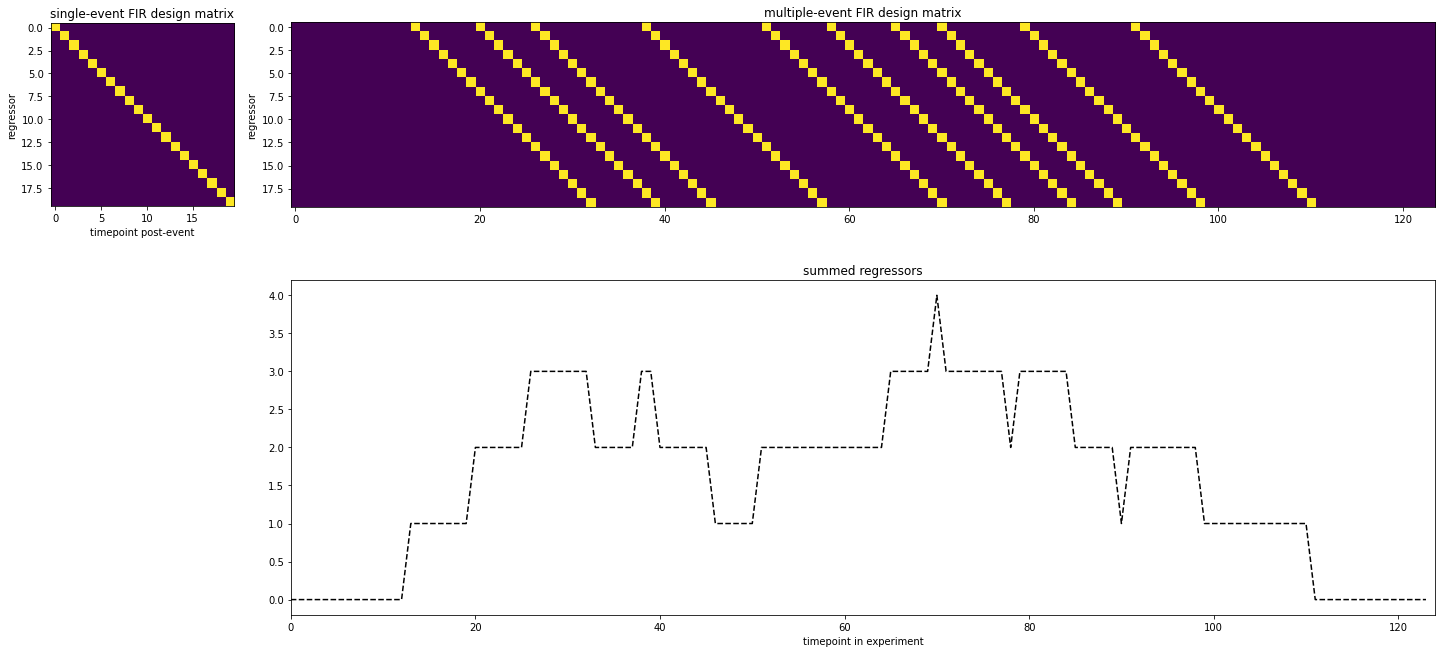

In [ ]:
# we'll assume, for now, that we're interested in 20 timepoints after the events
n_timepoints = 20
dm_one_event = np.eye(n_timepoints)

# we simulate some random event times, synced to the TR (important!): 
event_TRs = np.round(np.cumsum(3+np.random.exponential(scale=6, size=10))).astype(int)
total_dm = np.zeros((event_TRs[-1]+n_timepoints+event_TRs[0], n_timepoints))
for etr in event_TRs:
    total_dm[etr:etr+n_timepoints,:] += dm_one_event

# and some plotting code
plt.figure(figsize=(20,10))
ax1 = plt.subplot2grid((2, 6), (0, 0), colspan=1)
ax2 = plt.subplot2grid((2, 6), (0, 1), colspan=5)
ax3 = plt.subplot2grid((2, 6), (1, 1), colspan=5)

ax1.imshow(dm_one_event, aspect=1)
ax1.set_title('single-event FIR design matrix')
ax1.set_xlabel('timepoint post-event')
ax1.set_ylabel('regressor')
ax2.imshow(total_dm.T)
ax2.set_title('multiple-event FIR design matrix')
ax2.set_ylabel('regressor')
ax3.plot(total_dm.sum(1), 'k--')
ax3.set_title('summed regressors')
ax3.set_xlabel('timepoint in experiment')
ax3.set_xlim([0,event_TRs[-1]+n_timepoints+event_TRs[0]])
plt.tight_layout()

How does this design matrix allow us to capture stacked responses? Well, if BOLD responses are likely to be stacked together in the experiment - that is, due to events occurring close together, these regressors will all be trying to explain the same timepoints of data. This means that in the least-squares solution that the GLM obtains the signal variance will be distributed between the different regressors which stand for different post-event timepoints. If this still feels weird, please re-consult the explanation linked to above. 

For now, we'll continue with our actual signal time-courses and event times. 

In [ ]:
!ls /content/data/hrf_mapper_59k/

# we'll load all the different event times we have, but will focus on the stimulus presentations for now.
blink_times = np.loadtxt(os.path.join('/content/data/hrf_mapper_59k/', 'sub-012_ses-2_task-hrfmapper_run-1_blink-times.tsv'), delimiter='\t')
sacc_times = np.loadtxt(os.path.join('/content/data/hrf_mapper_59k/', 'sub-012_ses-2_task-hrfmapper_run-1_sacc-times.tsv'), delimiter='\t')
stim_times = np.loadtxt(os.path.join('/content/data/hrf_mapper_59k/', 'sub-012_ses-2_task-hrfmapper_run-1_stim-times.tsv'), delimiter='\t')

# and, for convenience, we'll also read in the confounds for later use here. 
# for example, the bold_confounds dataframe contains slow drift regressors...
# these are called CosineXXX.
import pandas as pd
bold_confounds = pd.read_csv(os.path.join('/content/data/hrf_mapper_59k/', 'sub-012_ses-2_task-hrfmapper_run-1_bold_confounds.tsv'), delimiter='\t')

sub-012_ses-2_task-hrfmapper_run-1_blink-times.tsv
sub-012_ses-2_task-hrfmapper_run-1_bold_confounds.tsv
sub-012_ses-2_task-hrfmapper_run-1_bold_space-T1w_preproc_59k.L.dtseries.gii
sub-012_ses-2_task-hrfmapper_run-1_bold_space-T1w_preproc_59k.R.dtseries.gii
sub-012_ses-2_task-hrfmapper_run-1_sacc-times.tsv
sub-012_ses-2_task-hrfmapper_run-1_stim-times.tsv


[ 19.843  25.508  34.967  38.742  43.468  49.136  58.593  63.318  71.819
  81.269  85.053  94.503 100.171 104.895 109.621 113.404 119.071 123.796
 133.247 137.03  140.805 145.531 150.256 162.541 167.273 171.048 176.724
 180.499 184.282 188.058 193.733 202.234 207.909 211.684 215.467 219.251
 223.026 231.535 236.26  240.985 245.71  249.486 257.996 270.278 281.62
 286.346 290.129 293.904 297.688 301.463 307.138 311.864 323.206 331.706
 337.381 343.048 347.773 351.558 356.282 364.783 376.125 379.908 388.409]


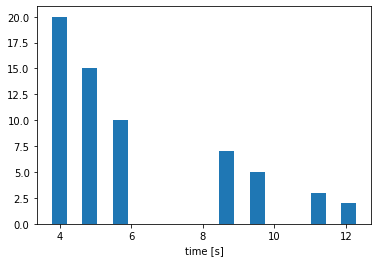

In [ ]:
# when were these events?
print(stim_times)
plt.hist(np.diff(stim_times), bins=20);
plt.xlabel('time [s]');

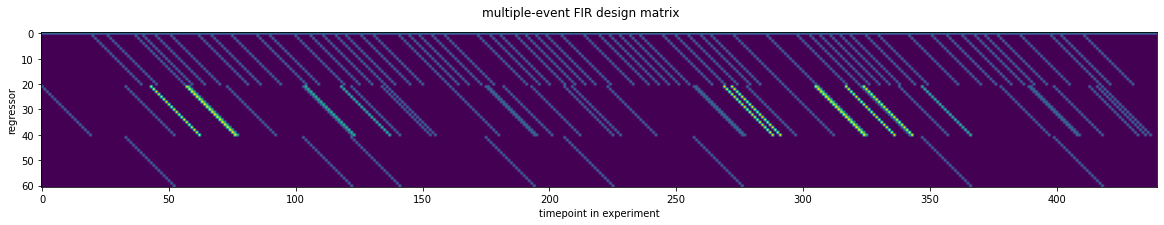

In [ ]:
# From the output above, you see that the events didn't occur at TR intervals. 
# we'll work with that in a bit. For now, we'll pretend that they did, and 
# round them off to the nearest TR (0.945s in this experiment)
tr = 0.945
event_TRs = np.round(stim_times/tr).astype(int)

stim_TRs = np.floor(stim_times/tr).astype(int)
sacc_TRs = np.floor(sacc_times/tr).astype(int)
blink_TRs = np.floor(blink_times/tr).astype(int)

# make sure no responses we try to fit run over the duration of our data
# this happens for the saccade times
event_TRs = event_TRs[event_TRs < (tseries_raw.shape[1] - n_timepoints)]

stim_TRs = stim_TRs[stim_TRs < (tseries_raw.shape[1] - n_timepoints)]
sacc_TRs = sacc_TRs[sacc_TRs < (tseries_raw.shape[1] - n_timepoints)]
blink_TRs = blink_TRs[blink_TRs < (tseries_raw.shape[1] - n_timepoints)]

# But hey, now we're almost in the same place as with our simulated events! 
# This means we can create the design matrix immediately by code we already used!
total_dm = np.zeros((tseries_raw.shape[1], n_timepoints))

sacc_dm = np.zeros((tseries_raw.shape[1], n_timepoints))
blink_dm = np.zeros((tseries_raw.shape[1], n_timepoints))
stim_dm = np.zeros((tseries_raw.shape[1], n_timepoints))

for etr in event_TRs:
    total_dm[etr:etr+n_timepoints,:] += np.eye(n_timepoints)

for etr in stim_TRs:
    stim_dm[etr:etr+n_timepoints,:] += np.eye(n_timepoints)
for etr in sacc_TRs:
    sacc_dm[etr:etr+n_timepoints,:] += np.eye(n_timepoints)
for etr in blink_TRs:
    blink_dm[etr:etr+n_timepoints,:] += np.eye(n_timepoints)


event_dm = np.hstack([stim_dm, sacc_dm, blink_dm])


# Then, if we were to just add an intercept and disregard our preprocessing, we 
# could start performing the GLM!

glm_dm = np.hstack((np.ones((1,tseries_raw.shape[1])).T, event_dm))

plt.figure(figsize=(20,3))
plt.imshow(glm_dm.T)
plt.suptitle('multiple-event FIR design matrix')
plt.ylabel('regressor')
plt.xlabel('timepoint in experiment');


In [ ]:
blink_dm.shape, stim_dm.shape, sacc_dm.shape, glm_dm.shape

((440, 20), (440, 20), (440, 20), (440, 61))

## Fitting the FIR model

Remember when we told you that the GLM is the basis for most of the analyses we do on fMRI data? This here is yet another example. Having built the design matrix, we can now perform a very simple GLM analysis, and we'll have our estimates of the BOLD response HRF shapes!

In [ ]:
# psc calculations can cause division by zero
tseries_psc = np.nan_to_num(psc(tseries_raw))

betas = np.linalg.lstsq(glm_dm, tseries_psc.T)[0]

yhat = np.dot(betas.T, glm_dm.T)
rsq = 1-(yhat-tseries_psc).var(1)/tseries_psc.var(1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [ ]:
# the rsq measure tells us where the voxels are whose signal is explained 
# using the FIR model. Not suprisingly, a simple visual stimulus causes
# BOLD responses mainly in low-level visual cortex.

cx.quickshow(cx.Vertex(rsq, subject='hcp_999999', cmap='inferno', vmin=0.05, vmax=0.25));

In [ ]:
# we could use this cell to plot all time-points as flatmaps.
# This allows you to see the BOLD response unfold on the surface of the cortex
# Plotting this many flatmaps is going to take a while, so use with caution.

f, sps = plt.subplots(n_timepoints, 1, figsize=(15,150))

for i, beta in enumerate(betas[1:]): # intercept is not so interesting :)
    cx.quickshow(cx.Vertex(beta*rsq, subject='hcp_999999', cmap='seismic', vmin=-3, vmax=3), fig=sps[i]);

In [ ]:
pd.DataFrame(responsive_V1_vertex_FIR_timecourses.T)#Each row is one timecourse

0         1         2   ...        57        58        59
0    0.351342  0.196209  0.914660  ... -0.212585  0.304451  0.428741
1    0.294617  0.160996  0.792622  ...  0.221822 -0.329790  0.313618
2    0.259976  0.304177  0.682959  ... -0.016455 -0.962822  0.229149
3    0.363881  0.441054  0.643587  ... -0.669307 -1.247687  0.092672
4    0.628270  0.489312  0.746846  ... -1.048878 -1.003217  0.281341
..        ...       ...       ...  ...       ...       ...       ...
186  0.250226  0.021264  1.183104  ... -0.643538 -0.063965  0.116026
187  0.416382  0.274759  1.003036  ... -0.466059 -0.140252  0.120380
188  0.242091  0.258239  0.671681  ... -0.231322 -0.222978  0.215761
189  0.479710  0.266813  0.887060  ... -0.574383 -0.338054  0.354700
190  0.356204  0.258095  0.425992  ... -0.405499 -0.470918  0.552982

[191 rows x 60 columns]

191 responsive voxels detected in V1 using threshold 0.6


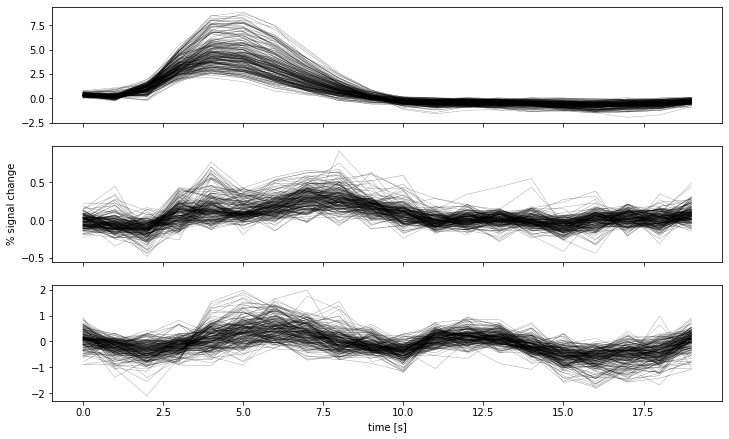

In [ ]:
rsq_threshold = 0.6
rsq_mask = rsq > rsq_threshold
V1_mask = atlas_data_both_hemis == roi_index_dict['V1']
V2_mask = atlas_data_both_hemis == roi_index_dict['V2']
V3_mask = atlas_data_both_hemis == roi_index_dict['V3']

responsive_V1_vertex_rsq = rsq[rsq_mask & V1_mask]
responsive_V2_vertex_rsq = rsq[rsq_mask & V2_mask]
responsive_V3_vertex_rsq = rsq[rsq_mask & V3_mask]

responsive_V1_vertex_FIR_timecourses = betas[1:,rsq_mask & V1_mask]

responsive_V1_vertex_FIR_stim_tc = betas[1:21,rsq_mask & V1_mask]
responsive_V1_vertex_FIR_sacc_tc = betas[21:41,rsq_mask & V1_mask]
responsive_V1_vertex_FIR_blink_tc = betas[41:,rsq_mask & V1_mask]


print(f'{responsive_V1_vertex_FIR_timecourses.shape[1]} responsive voxels detected in V1 using threshold {rsq_threshold}')

fig,axes = plt.subplots(3,1, sharex=True,figsize=(12,7.25))
for i, tc in enumerate(responsive_V1_vertex_FIR_stim_tc.T):
    axes[0].plot(tc[:20], c='k', lw=0.25, alpha=responsive_V1_vertex_rsq[i]);
for i, tc in enumerate(responsive_V1_vertex_FIR_sacc_tc.T):
    axes[1].plot(tc[:20], c='k', lw=0.25, alpha=responsive_V1_vertex_rsq[i]);
for i, tc in enumerate(responsive_V1_vertex_FIR_blink_tc.T):
    axes[2].plot(tc[:20], c='k', lw=0.25, alpha=responsive_V1_vertex_rsq[i]);
  
axes[-1].set_xlabel('time [s]');
axes[1].set_ylabel('% signal change');


182 responsive voxels detected in V1 using threshold 0.6


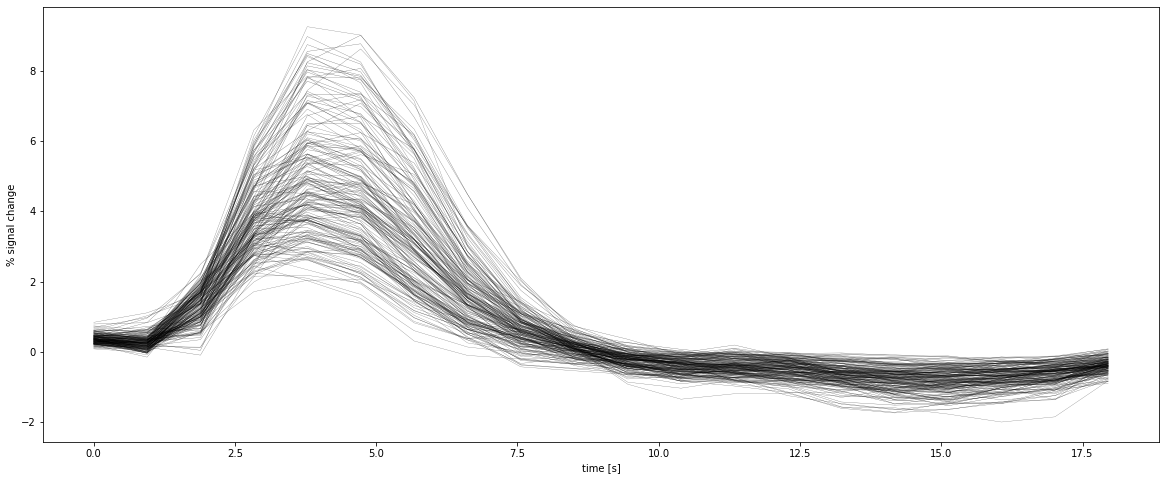

In [ ]:
rsq_threshold = 0.6
rsq_mask = rsq > rsq_threshold
V1_mask = atlas_data_both_hemis == 1

responsive_V1_vertex_rsq = rsq[rsq_mask & V1_mask]
responsive_V1_vertex_FIR_timecourses = betas[1:,rsq_mask & V1_mask]
# how many?
print(f'{responsive_V1_vertex_FIR_timecourses.shape[1]} responsive voxels detected in V1 using threshold {rsq_threshold}')

plt.figure(figsize=(20,8))
for i, tc in enumerate(responsive_V1_vertex_FIR_timecourses.T):
    plt.plot(np.arange(n_timepoints)*tr, tc, c='k', lw=0.25, alpha=responsive_V1_vertex_rsq[i]);
plt.xlabel('time [s]')
plt.ylabel('% signal change');

## Your task

Like with each of the other projects, your mission is to try to perform as many as possible of the underlying tasks. **Note:** You **do NOT** have to do them all for a passing grade. But, as with any project you sometimes have to cut things short and write up the results you do have, instead of keep working on creating more results. 

1. We have a lot more information about the experiment than just the stimulus presentation times: we have eyetracking results, so we know when the subject made an eye movement, and when he blinked (in the `sacc_times` and `blink_times` variables, respectively). What happens when you add these to the design matrix as separate time-courses to be estimated? Pick the best-fitting voxel for each of V1, V2, and V3, and plot its time-course for all three types of event: **stimulus, blink, and saccade**. Also plot the average response-time-course in V1, V2, and V3. **BONUS:** add the 95% confidence interval across voxels in each region as a shaded region to these latter plots.  
2. We also have a bunch of slow drift and nuisance regressors that we may want to incorporate. This is likely going to make our fits, in rsq, a lot better. But does this make the estimated time-courses any better? Check this, by adding the aCompCorr, tCompCorr, CosineXXX, and FD/DVARS regressors to your design matrix. Make sure you change the np.nan values in those regressors before you try the GLM. The outcome: a re-plot of the average response time-courses for V1, V2, and V3 - but also that same voxel you plotted before (the best-fitting one from question 1). The goal is to plot these HRF shapes with and without the confounds. Does the HRF shape change as a result of adding nuisance regressors to the design matrix?
    - What's really cool is that we can also investigate how the nuisances map onto the surface. So, plot the T-statistic for each of the aCompCorr regressors onto flatmaps to inspect this. Do these regions overlap with the earlier rsq visualization?
3. But wait. When we think deeply about what we're doing right now, something is off. You saw that the events in our experiment happened at random times, and not at every TR! This means we're throwing away a lot of timing-related information by rounding event times to the TR, and that's a big, big shame. There are a couple of ways of trying to fix this, but the easiest is to pretend we have more data timepoints than we do have. Specifically, we can 'harmonica' the data by a factor of three (i.e. the sequence of values [2.3, 4.5, 2.1] in the time-course would become [2.3, 2.3, 2.3, 4.5, 4.5, 4.5, 2.1, 2.1, 2.1]) so that our made-up TR is now 1/3 of what it used to be (we could also do 4, 5, 6 etc. for a 1/4, 1/5 or 1/6 made-up TR). Then, we can round the event times in our experiment to that made-up TR -- effectively increasing the time resolution of our analysis by a factor of 3 (or 4, 5, or 6). Because the experimental events were jittered across the TR, this actually lets us capture the shape of the BOLD response at a higher temporal precision. But of course, you will understand from all of our degrees-of-freedom discussions that when we do something like this we cannot use the standard statistics. Luckily, we care only for the shape of the BOLD response here. Your task is to perform the analysis you performed at point 2 with 3-fold 'harmonica' of the data (using the numpy function [numpy.repeat](https://numpy.org/doc/stable/reference/generated/numpy.repeat.html)). Remember to handle the nuisance factors correctly also! Show the results for the best-fitting voxels and average of V1, V1, and V3 with the appropriate time axis, again for each of the 3 types of events in the experiment. Discuss why this trick works in your report, and what its downsides and/or caveats are.... 
4. Another way of fitting the response shapes is to use a different set of basis functions, for example a standard HRF and its time and dispersion derivative. You can import these functions as follows: 
`from nilearn.glm.first_level.hemodynamic_models import spm_hrf, spm_time_derivative, spm_dispersion_derivative`
This means that you can perform a GLM, where the beta weights for each of these HRF shapes together determine the shape of the BOLD response for that vertex/voxel. Does this analysis result in similar shape estimates as the full, smooth FIR version that you did here? You can look at the 10 best voxels and draw your conclusions. 
5. **bonus** We looked at veins in the raw data section of the introduction. If you've read the advanced Kay et al paper, you'll know that venous contributions actually impact the shape of the HRF. Veins show up as darker voxels in a T2* EPI image like we have here. Your task is to investigate whether vein contribution changes the shape of the BOLD response in visual cortex. Plot the average HRF shape for dimmer and brighter voxels in each region separately. Since we're interested in the shape of the HRF, it will work best if you normalize the BOLD responses, i.e. divide them by their maximal value (per vertex/voxel) so that the peaks line up on the y-axis. You will understand that this works best at as high as possible time resolution of the analysis, since then we will have the best estimate of the shape of the BOLD response.
6. **bonus** **bonus** If you're completely on a roll, feel free to also do the pRF project, and use the fitted HRF from this project there. You can find a more detailed explanation of how to do this in that project's Task explanation. **Note:** This is a very advanced assignment. You don't have to do this at all. But if you pull it off, that's bonus points and I would recommend you to anyone who is searching for PhD students :) 


# Report Outline

This part of the notebook outlines the sections we expect your report to contain. You can use this part as a to-be-filled-in template for your project report. The total text should not be too long, so that you don't needlessly pain your long-suffering colleagues. Say, 2000 words max. 



## Title 

a title is more important than you think - a good title draws the reader in. An excellent title is a bit playful without going over the top. Before you finish the report, spend a few minutes brainstorming on the perfect title. It pays off.

## Abstract

An abstract is a brief (say, around 200 words) summary of the research, methods, as well as the findings and their significance. 

## Introduction

Why this research? What does this specific experiment teach us about the brain? Be sure to discuss the articles that go with your project, and any and all additional articles that you've found. Feel free to add figures from published articles to clarify the approach. 

## Methods 

In the methods section, you should describe the experiment and your analyses in as much detail as possible, or at least to the level of detail required for others to replicate your findings. Clearly you don't have all the information regarding scanning parameters, etc, so we won't fault you for not including those here. 

## Results

It's easiest to base your results section around a few (say, 4 or 5) key figures that illustrate what you've done and what you've found. These can be illustrations, flatmaps, time-courses and/or anything that you decide is a cool visualization of your results. You can start with a description of the data as you're getting it, basing yourself on the *Questions concerning signal quality* etc. above. 

Be sure to describe your figures with adequate captions. For these results, we will focus on qualitative descriptions and not so much on hard stats - which are harder to do on single subjects. 

I hope you will have fun creating this project and I also hope that your findings will reflect the fun you have. 

## Discussion

*   What have we learned? 
*   What should others be aware of? 
*   In what sense do your findings correspond to the literature you know, and in what sense do your findings deviate from the canon? 

What have you learned?

Feel free to add references that you've stumbled upon yourselves. 